In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.RL_functions.helpers import get_look_back_time_steps, hidden_states_collector
from src.RL_functions.actor_critic_kf import *
from scipy.stats import multivariate_normal
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential, ReLU, EvenExp

In [2]:
# Load samples
samples = pd.read_csv('data/hsl_synthetic_samples_rand_anmmag_new_stationary.csv')
samples['LTd_history'] = samples['LTd_history'].apply(lambda x: list(map(float, x[1:-1].split(','))))
# Convert samples['anm_develop_time'] to float
samples['anm_develop_time'] = samples['anm_develop_time'].apply(lambda x: float(x))

# Shuffle samples
samples = samples.sample(frac=1).reset_index(drop=True)

# Target list
target_list = ['itv_LT', 'itv_LL', 'anm_develop_time']

In [3]:
# Use pytorch to train a Fully Connected Neural Network
# Input: samples['LTd_history']
# Output: samples['itv_LT'], samples['itv_LT'], samples['anm_develop_time']

# Define the model working with dtype float 64
class TAGI_Net():
    def __init__(self, n_observations, n_actions):
        super(TAGI_Net, self).__init__()
        self.net = Sequential(
                    Linear(n_observations, 64),
                    # Linear(n_observations, 64, gain_weight=0.1, gain_bias=0.1),
                    ReLU(),
                    Linear(64, 32),
                    # Linear(64, 32, gain_weight=0.1, gain_bias=0.1),
                    ReLU(),
                    Linear(32, n_actions * 2),
                    # Linear(32, n_actions * 2, gain_weight=0.1, gain_bias=0.1),
                    EvenExp()
                    )
        self.n_actions = n_actions
        self.n_observations = n_observations
    def forward(self, mu_x, var_x):
        return self.net.forward(mu_x, var_x)
    
model = TAGI_Net(len(samples['LTd_history'][0]), len(target_list))

# Train the model using 50% of the samples
n_samples = len(samples)
n_train = int(n_samples * 0.5)
train_samples = samples.iloc[:n_train]
train_X = np.array(train_samples['LTd_history'].values.tolist(), dtype=np.float32)
train_y = np.array(train_samples[target_list].values, dtype=np.float32)
# Get the moments of training set, and use them to normalize the validation set and test set
mean_train = train_X.mean()
std_train = train_X.std()
train_X = (train_X - mean_train) / std_train
mean_target = train_y.mean(axis=0)
std_target = train_y.std(axis=0)
# # Remove when using time series with different anomaly magnitude
# std_target[0] = 1
# mean_target[0] = 0
train_y = (train_y - mean_target) / std_target

# Validation set 10% of the samples
n_val = int(n_samples * 0.1)
val_samples = samples.iloc[n_train:n_train+n_val]
val_X = np.array(val_samples['LTd_history'].values.tolist(), dtype=np.float32)
val_y = np.array(val_samples[target_list].values, dtype=np.float32)
val_X = (val_X - mean_train) / std_train
val_y = (val_y - mean_target) / std_target

# Train the model with batch size 20
batch_size = 20
n_batch_train = n_train // batch_size
n_batch_val = n_val // batch_size
patience = 10
best_loss = float('inf')
max_training_epoch = 10
# for epoch in range(max_training_epoch):
for epoch in range(max_training_epoch):
    for i in range(n_batch_train):
        prediction_mu, prediction_var = model.net(train_X[i*batch_size:(i+1)*batch_size])
        prediction_mu = prediction_mu.reshape(batch_size, len(target_list)*2)

        # Update model
        out_updater = OutputUpdater(model.net.device)
        out_updater.update_heteros(
            output_states = model.net.output_z_buffer,
            mu_obs = train_y[i*batch_size:(i+1)*batch_size].flatten(),
            # var_obs = np.zeros_like(train_y[i*batch_size:(i+1)*batch_size].flatten()),
            var_obs = np.zeros_like(train_y[i*batch_size:(i+1)*batch_size].flatten()),
            delta_states = model.net.input_delta_z_buffer,
        )
        model.net.backward()
        model.net.step()

    loss_val = 0
    for j in range(n_batch_val):
        val_pred_mu, val_pred_var = model.net(val_X[j*batch_size:(j+1)*batch_size])
        val_pred_mu = val_pred_mu.reshape(batch_size, len(target_list)*2)
        val_pred_y_mu = val_pred_mu[:, [0, 2, 4]]
        val_y_batch = val_y[j*batch_size:(j+1)*batch_size]
        # Compute the mse between val_pred_y_mu and val_y_batch
        loss_val += ((val_pred_y_mu - val_y_batch)**2).mean()
    loss_val /= n_batch_val

    print(f'Epoch {epoch}: {loss_val}')
    # Early stopping with patience 10
    if loss_val < best_loss:
        best_loss = loss_val
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            break

Epoch 0: 0.4651528045310447
Epoch 1: 0.4619027253745788
Epoch 2: 0.4605261939629238
Epoch 3: 0.45976282182201067
Epoch 4: 0.4592708867249177
Epoch 5: 0.4588753804789117
Epoch 6: 0.4585557693587476
Epoch 7: 0.4581787800594191
Epoch 8: 0.4572510401807239
Epoch 9: 0.4569529446001029


In [4]:
# Test the model using 10% of the samples
n_test = int(n_samples * 0.1)
test_samples = samples.iloc[n_train+n_val:n_train+n_val+n_test]
test_X = np.array(test_samples['LTd_history'].tolist(), dtype=np.float32)
test_y = np.array(test_samples[target_list].values, dtype=np.float32)
test_X = (test_X - mean_train) / std_train
test_y = (test_y - mean_target) / std_target

n_batch_test = n_test // batch_size

loss_test = 0
for j in range(n_batch_val):
    test_pred_mu, test_pred_var = model.net(test_X[j*batch_size:(j+1)*batch_size])
    test_pred_mu = test_pred_mu.reshape(batch_size, len(target_list)*2)
    test_pred_y_mu = test_pred_mu[:, [0, 2, 4]]
    test_pred_y_var = test_pred_mu[:, [1, 3, 5]]
    test_y_batch = test_y[j*batch_size:(j+1)*batch_size]
    # Compute the mse between test_pred_y_mu and test_y_batch
    loss_test += ((test_pred_y_mu - test_y_batch)**2).mean()
loss_test /= n_batch_test

print(f'Test loss {loss_test.item()}')

# Denormalize the prediction
y_pred_denorm = test_pred_y_mu * std_target + mean_target
y_pred_var_denorm = test_pred_y_var * std_target ** 2
y_test_denorm = test_y_batch * std_target + mean_target
print(y_test_denorm.tolist())
print(y_pred_denorm.tolist())
print(np.sqrt(y_pred_var_denorm))

Test loss 0.4488794028197401
[[0.0, 0.0, 0.0], [-0.23238468170166016, -15.56977367401123, 67.0], [-0.08918195217847824, -10.166742324829102, 114.0], [0.0, 0.0, 0.0], [0.03286350518465042, 4.732344627380371, 144.0], [-0.22929559648036957, -9.630414962768555, 42.0], [-0.032410215586423874, -5.83383846282959, 180.0], [-0.38725927472114563, -28.269927978515625, 73.0], [-0.32797375321388245, -22.302217483520508, 68.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.2726174294948578, 0.5452348589897156, 2.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.24089255928993225, -19.0305118560791, 79.0], [0.04612739756703377, 4.013083457946777, 87.0]]
[[9.930785745382309e-05, 0.004586726427078247, 0.256561279296875], [-0.11124437302350998, -8.673819541931152, 69.62340545654297], [0.08411695808172226, 4.7060065269470215, 64.80699157714844], [5.422160029411316e-06, 0.0009267628192901611, -0.27046966552734375], [0.009904995560646057, 1.662021636962890

# Test in time series

In [5]:
# Test the model on one synthetic time series
# Load test time series
import pandas as pd
data = pd.read_csv('data/hsl_test_time_series_rand_anmmag_long.csv')
data['y'] = data['y'].apply(lambda x: list(map(float, x[1:-1].split(','))))
# Convert data['timesteps'][0] from list of str to list of float
data['timesteps'][0] = list(map(float, data['timesteps'][0][1:-1].split(',')))
data['anm_mag'] = data['anm_mag'].apply(lambda x: float(x))
data['anm_pos'] = data['anm_pos'].apply(lambda x: int(x))

# Time series config
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = len(data['y'][0])
num_ts = 10

/var/folders/vv/62ff9wx97g72zr4_20vx1q3h0000gn/T/ipykernel_3489/4196982104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timesteps'][0] = list(map(float, data['timesteps'][0][1:-1].split(',')))


In [6]:
# # Config for the base and drift models
components = ['trend','fourrier', 'ar']
components_d = ['trend', 'ar']

hyperparameters = {'trend': {'process_error_var': 0},
                    'fourrier': {'period': 52, 'process_error_var': 0},
                    'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                    'observation': {'error': 1e-6}}
hyperparameters_d = {'trend': {'process_error_var': 0, 'phi': 1},
                    'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                    'observation': {'error': 1e-6}}

x_init = {'mu': np.array([5, 0, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
            'var': np.diag([1e-12, 1E-12, 1e-12, 1E-12, 6.36E-05])}
x_init_d = {'mu': np.array([0, 0.0, -0.0621]), \
            'var': np.diag([1e-12, 1e-12, 6.36E-05])}

baseline_process_error_var_all = [1e-6]

In [7]:
# kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)
# x_samples_mean_all, x_samples_cov_all = [], []
# for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
#     hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
#     kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
#     x_samples_mean, x_samples_cov = estimate_hs_distribution(components, time_step_interval, hyperparameters, num_steps, x_init, x_init_d, kf, kf_d)
#     x_samples_mean_all.append(x_samples_mean)
#     x_samples_cov_all.append(x_samples_cov)
#     print(x_samples_mean, x_samples_cov)

# Hidden state distribution provided by users
x_samples_mean_all = [-0.00080167]
x_samples_cov_all = [2.0644215838756797e-05]

In [59]:
# Analyze the time series using base and drift models
samples = {'LTd_history': [], 'itv_LT': [], 'itv_LL': [], 'anm_develop_time': []}

kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)
prior_a = [0.998, 0.002]

ts_n = 7

x_likelihood_na_all = []
x_likelihood_a_all = []
y_likelihood_na_all = []
y_likelihood_a_all = []
trigger_pos = []

x_last_step = x_init
x_last_step_d = x_init_d

mv_normal_x_all = []
scale_factors_all = []

intervene = False
intervention_state = None
anomaly_detected = False

for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
    x_samples_mean, x_samples_cov = x_samples_mean_all[j], x_samples_cov_all[j]
    mv_normal_x = multivariate_normal(mean=x_samples_mean, cov=x_samples_cov, allow_singular=True)
    mv_normal_x_all.append(mv_normal_x)
    scale_factors_all.append(mv_normal_x.pdf(x_samples_mean))

p_na_I_Mj_Yt1 = prior_a[0]
p_a_I_Mj_Yt1 = prior_a[1]
p_Mj_I_Yt_all = []
p_a0_all = []
LL_mu, LT_mu, AR_mu, y_pred_mus = [], [], [], []
LL_var, LT_var, AR_var, y_pred_vars = [], [], [], []
LTd_all = {'mu': [], 'var': []}
plot_model_index = 0
LLj_mu, LTj_mu, ARj_mu, yj_pred_mus, LLjd_mu, LTjd_mu, ARjd_mu, yjd_pred_mus = [], [], [], [], [], [], [], []
LLj_var, LTj_var, ARj_var, yj_pred_vars, LLjd_var, LTjd_var, ARjd_var, yjd_pred_vars  = [], [], [], [], [], [], [], []
for i in range(num_steps):
    xd_updated_remain_all = []
    x_y_likelihood = []
    for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
        hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
        kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
        x_last_step_d = x_init_d if i==0 else x_last_step_d_all[j]

        intervention_state = copy.deepcopy(x_last_step)
        intervention_state['mu'][0] += x_last_step_d['mu'][0]
        intervention_state['mu'][1] += x_last_step_d['mu'][1]
        intervention_state['var'][0,0] += x_last_step_d['var'][0,0]
        intervention_state['var'][1,1] += x_last_step_d['var'][1,1]
        intervention_state['mu'][-1] = x_last_step_d['mu'][-1]
        intervention_state['var'][-1,-1] = x_last_step_d['var'][-1,-1]

        if j==plot_model_index:
            y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na,\
                _, xd_updated_remain, _, _, x_pred, xd_pred, _, yj_pred, _, ar_pred = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data['y'][ts_n][i], mv_normal_x_all[j])
        else:
            y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na,\
                _, xd_updated_remain, _, _, _, xd_pred, _, _, _, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data['y'][ts_n][i], mv_normal_x_all[j])
        x_likelihood_a *= 1/scale_factors_all[j]
        x_likelihood_na *= 1/scale_factors_all[j]

        x_y_likelihood.append([x_likelihood_na.item(), x_likelihood_a.item(), y_likelihood_na.item(), y_likelihood_a.item()])
        xd_updated_remain_all.append(xd_updated_remain)

    x_y_likelihood_array = np.array(x_y_likelihood)
    p_yt_I_Mj_Yt1 = x_y_likelihood_array[:, 2] * x_y_likelihood_array[:, 0] * p_na_I_Mj_Yt1 + x_y_likelihood_array[:, 3] * x_y_likelihood_array[:, 1] * p_a_I_Mj_Yt1
    p_na_I_Mj_Yt = x_y_likelihood_array[:, 2] * x_y_likelihood_array[:, 0] * p_na_I_Mj_Yt1 / p_yt_I_Mj_Yt1
    p_a_I_Mj_Yt = x_y_likelihood_array[:, 3] * x_y_likelihood_array[:, 1] * p_a_I_Mj_Yt1 / p_yt_I_Mj_Yt1

    # Compute probability of taking intervention or not
    p_Mj_I_Yt = p_yt_I_Mj_Yt1 / np.sum(p_yt_I_Mj_Yt1)   # Probability of each model
    p_a0 = np.sum(p_na_I_Mj_Yt * p_Mj_I_Yt)             # Probability of not requiring intervention by all models

    p_Mj_I_Yt_all.append(p_Mj_I_Yt.tolist())
    p_a0_all.append(p_a0)

    if i > data['anm_pos'][ts_n]:
        # Look back history for LTd
        LTd_history = hidden_states_collector(i - 1, LTd_all)
        samples['LTd_history'].append(LTd_history['mu'].tolist())
        if anomaly_detected:
            samples['itv_LT'].append(data['anm_mag'][ts_n] * 0)
            samples['anm_develop_time'].append(0)
            samples['itv_LL'].append(data['anm_mag'][ts_n] * 0)
        else:
            samples['itv_LT'].append(data['anm_mag'][ts_n])
            anm_develop_time = i - 1 - data['anm_pos'][ts_n]
            samples['anm_develop_time'].append(anm_develop_time)
            samples['itv_LL'].append(data['anm_mag'][ts_n] * anm_develop_time)

        current_hitory = np.array(samples['LTd_history'][-1], dtype=np.float32)
        current_hitory = (current_hitory - mean_train) / std_train
        # Repeat the history to match the batch size
        current_hitory = np.repeat(current_hitory[np.newaxis, :], batch_size, axis=0)
        output_pred_mu, output_pred_var = model.net(current_hitory)
        output_pred_mu = output_pred_mu.reshape(batch_size, len(target_list)*2)
        output_pred_var = output_pred_var.reshape(batch_size, len(target_list)*2)
        itv_pred_mu = output_pred_mu[0, [0, 2, 4]]
        itv_pred_var = output_pred_mu[0, [1, 3, 5]]
        itv_pred_mu_denorm = itv_pred_mu * std_target + mean_target
        itv_pred_var_denorm = itv_pred_var * std_target ** 2

    if p_a0 <= 0.5:
        print(i)
        look_back_idx_list = get_look_back_time_steps(i -1)
        ltd_history_sample = samples['LTd_history'][-1]

        intervene = True
        anomaly_detected = True
        trigger_pos.append(i)
        intervention_state = copy.deepcopy(x_init)
        # # Perfect intervention
        # intervention_state['mu'][1] = x_init['mu'][1] + samples['itv_LT'][-1]
        # intervention_state['mu'][0] = x_init['mu'][0] + samples['itv_LL'][-1]
        # intervention_state['mu'][-1] = x_last_step['mu'][-1] - samples['itv_LL'][-1]

        # # NN intervention
        intervention_state['mu'][1] = x_last_step['mu'][1] + itv_pred_mu_denorm[0]
        intervention_state['mu'][0] = x_last_step['mu'][0] + itv_pred_mu_denorm[1]
        intervention_state['mu'][-1] = x_last_step['mu'][-1] - itv_pred_mu_denorm[1]
        # Variance of baseline increased
        intervention_state['var'][0,0] = x_last_step['var'][0,0] + itv_pred_var_denorm[1]
        intervention_state['var'][1,1] = x_last_step['var'][1,1] + itv_pred_var_denorm[0]

        intervention_state['mu'][2] = x_last_step['mu'][2]
        intervention_state['mu'][3] = x_last_step['mu'][3]

        # Update the critic models based on the actual intervention taken
        xd_updated_intervene_all = []
        x_y_likelihood = []
        for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
            hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
            kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
            x_last_step_d = x_init_d if i==0 else x_last_step_d_all[j]

            if j==plot_model_index:
                y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na, xd_updated_intervene, _, x_pred, xd_pred, _, _, yj_pred, _, ar_pred, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data['y'][0][i], mv_normal_x_all[j])
            else:
                y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na, xd_updated_intervene, _, _, xd_pred, _, _, _, _, _, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data['y'][0][i], mv_normal_x_all[j])
            x_y_likelihood.append([x_likelihood_na.item(), x_likelihood_a.item(), y_likelihood_na.item(), y_likelihood_a.item()])
            xd_updated_intervene_all.append(xd_updated_intervene)
    else:
        intervene = False

    x_pred, y_pred, x_last_step = actor(kf, x_last_step, intervene, intervention_state, data['y'][ts_n][i])

    # Store all LTd for history collection
    LTd_all['mu'].append(xd_pred['mu'][1])
    LTd_all['var'].append(xd_pred['var'][1,1])

    LL_mu.append(x_pred['mu'][0])
    LT_mu.append(x_pred['mu'][1])
    AR_mu.append(x_pred['mu'][-1])
    LL_var.append(x_pred['var'][0,0])
    LT_var.append(x_pred['var'][1,1])
    AR_var.append(x_pred['var'][-1,-1])
    y_pred_mus.append(y_pred['mu'].item())
    y_pred_vars.append(y_pred['var'].item())

    LLj_mu.append(x_pred['mu'][0])
    LTj_mu.append(x_pred['mu'][1])
    ARj_mu.append(x_pred['mu'][-1])
    LLj_var.append(x_pred['var'][0,0])
    LTj_var.append(x_pred['var'][1,1])
    ARj_var.append(x_pred['var'][-1,-1])
    LLjd_mu.append(xd_pred['mu'][0])
    LTjd_mu.append(xd_pred['mu'][1])
    ARjd_mu.append(xd_pred['mu'][-1])
    LLjd_var.append(xd_pred['var'][0,0])
    LTjd_var.append(xd_pred['var'][1,1])
    ARjd_var.append(xd_pred['var'][-1,-1])
    yj_pred_mus.append(yj_pred['mu'].item())
    yj_pred_vars.append(yj_pred['var'].item())
    yjd_pred_mus.append(ar_pred['mu'])
    yjd_pred_vars.append(ar_pred['var'])

    x_last_step_d_all = xd_updated_intervene_all if intervene else xd_updated_remain_all


295


In [60]:
itv_pred_mu_denorm_all = []
itv_pred_var_denorm_all = []
for i in range(len(samples['LTd_history'])):
    test_X = np.array(samples['LTd_history'][i], dtype=np.float32)
    test_X = (test_X - mean_train) / std_train
    test_X = np.repeat(test_X[np.newaxis, :], batch_size, axis=0)
    output_pred_mu, output_pred_var = model.net(test_X)
    output_pred_mu = output_pred_mu.reshape(batch_size, len(target_list)*2)
    output_pred_var = output_pred_var.reshape(batch_size, len(target_list)*2)
    itv_pred_mu = output_pred_mu[0, [0, 2, 4]]
    itv_pred_var = output_pred_mu[0, [1, 3, 5]]
    itv_pred_mu_denorm = itv_pred_mu * std_target + mean_target
    itv_pred_var_denorm = itv_pred_var * std_target ** 2
    itv_pred_mu_denorm_all.append(itv_pred_mu_denorm.tolist())
    itv_pred_var_denorm_all.append(itv_pred_var_denorm.tolist())

itv_pred_mu_denorm_all = np.array(itv_pred_mu_denorm_all)
itv_pred_var_denorm_all = np.array(itv_pred_var_denorm_all)

# Set time index for y_pred_denorm from anm_pos to anm_pos + len(y_pred_denorm)
time_index_prediction = np.arange(data['anm_pos'][ts_n], data['anm_pos'][ts_n] + len(itv_pred_mu_denorm_all))

Text(0, 0.5, 'itv_anm_dev')

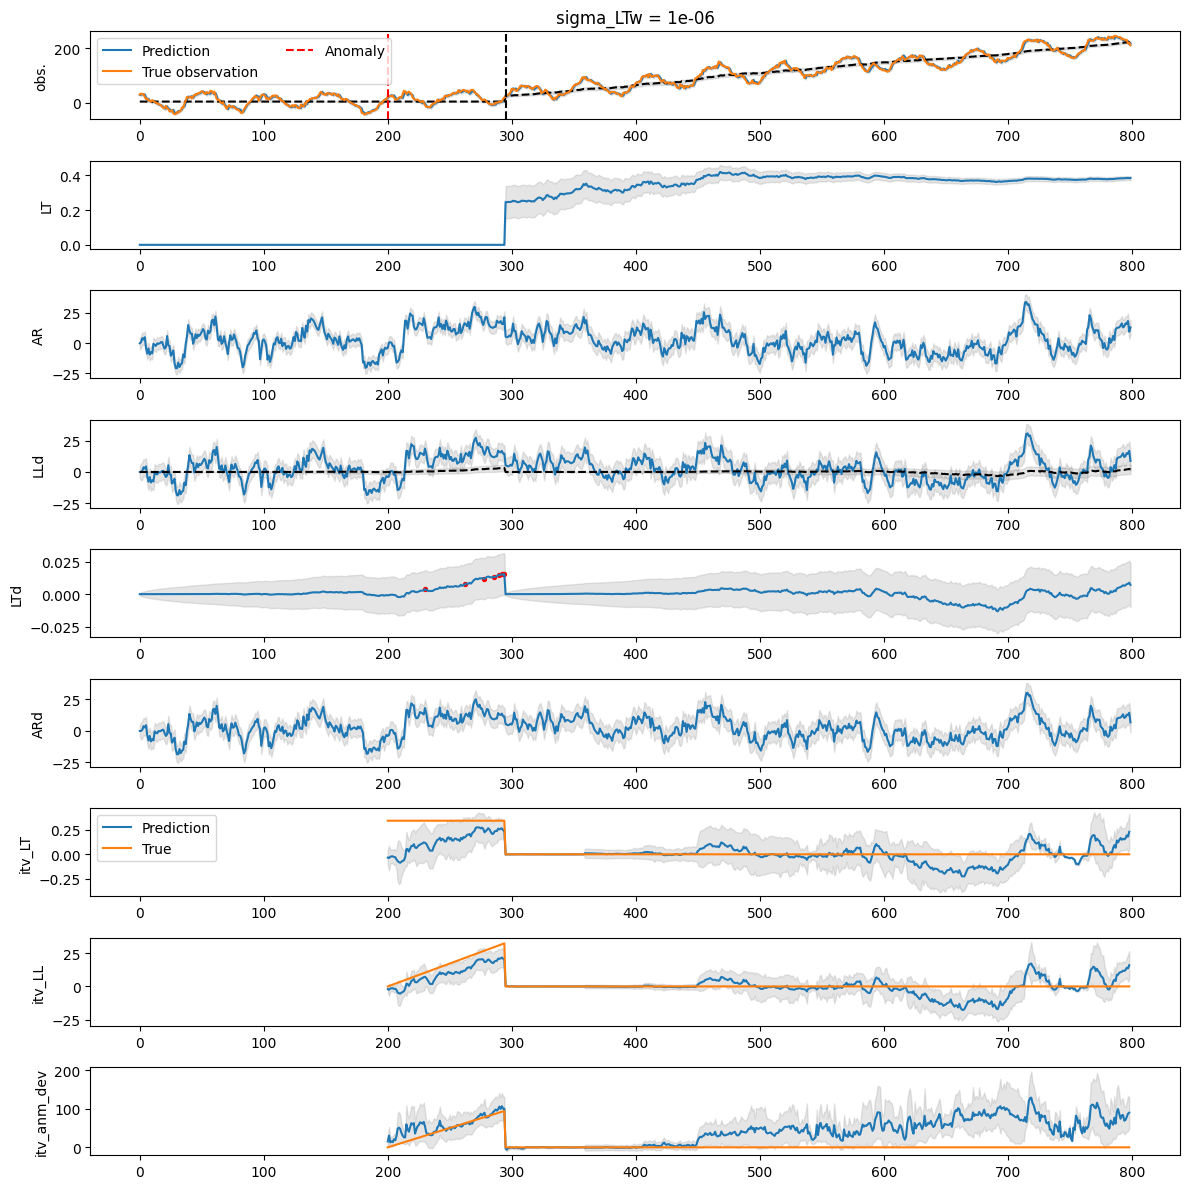

In [61]:
# Plot critic model
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(9, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
ax8 = plt.subplot(gs[8])

############ Base model ############
ax0.plot(data['timesteps'][0], yj_pred_mus, label='Prediction')
ax0.fill_between(data['timesteps'][0], np.array(yj_pred_mus)-np.sqrt(yj_pred_vars), np.array(yj_pred_mus)+np.sqrt(yj_pred_vars),color='gray', alpha=0.2)
ax0.plot(data['timesteps'][0], LLj_mu, 'k--')
ax0.fill_between(data['timesteps'][0], np.array(LLj_mu)-np.sqrt(LLj_var), np.array(LLj_mu)+np.sqrt(LLj_var),color='gray', alpha=0.2)
ax0.plot(data['timesteps'][0], data['y'][ts_n], label='True observation')
if data['anm_mag'][0] != 0:
    ax0.axvline(x=data['anm_pos'][0], color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax0.axvline(x=trigger, color='k', linestyle='--')
ax0.legend(loc='upper left', ncol = 2)
ax0.set_ylabel('obs.')
ax0.set_title('sigma_LTw = ' + str(baseline_process_error_var_all[plot_model_index]))

ax1.plot(data['timesteps'][0], LTj_mu, label='Prediction')
ax1.fill_between(data['timesteps'][0], np.array(LTj_mu)-np.sqrt(LTj_var), np.array(LTj_mu)+np.sqrt(LTj_var),color='gray', alpha=0.2)
ax1.set_ylabel('LT')

ax2.plot(data['timesteps'][0], ARj_mu, label='Prediction')
ax2.fill_between(data['timesteps'][0], np.array(ARj_mu)-np.sqrt(ARj_var), np.array(ARj_mu)+np.sqrt(ARj_var),color='gray', alpha=0.2)
ax2.set_ylabel('AR')

############ Critic model ############
ax3.plot(data['timesteps'][0], yjd_pred_mus, label='Prediction')
ax3.fill_between(data['timesteps'][0], np.array(yjd_pred_mus)-np.sqrt(yjd_pred_vars), np.array(yjd_pred_mus)+np.sqrt(yjd_pred_vars),color='gray', alpha=0.2)
ax3.plot(data['timesteps'][0], LLjd_mu, 'k--')
ax3.fill_between(data['timesteps'][0], np.array(LLjd_mu)-np.sqrt(LLjd_var), np.array(LLjd_mu)+np.sqrt(LLjd_var),color='gray', alpha=0.2)
ax3.set_ylabel('LLd')

ax4.plot(data['timesteps'][0], LTjd_mu, label='Prediction')
ax4.fill_between(data['timesteps'][0], np.array(LTjd_mu)-np.sqrt(LTjd_var), np.array(LTjd_mu)+np.sqrt(LTjd_var),color='gray', alpha=0.2)
ax4.scatter(look_back_idx_list, ltd_history_sample, 8, color='r', label='LTd history')
ax4.set_ylabel('LTd')

ax5.plot(data['timesteps'][0], ARjd_mu, label='Prediction')
ax5.fill_between(data['timesteps'][0], np.array(ARjd_mu)-np.sqrt(ARjd_var), np.array(ARjd_mu)+np.sqrt(ARjd_var),color='gray', alpha=0.2)
ax5.set_ylabel('ARd')

############ Prediction ############
ax6.plot(time_index_prediction, itv_pred_mu_denorm_all[:,0], label='Prediction')
ax6.fill_between(time_index_prediction, itv_pred_mu_denorm_all[:,0]-np.sqrt(itv_pred_var_denorm_all[:,0]), itv_pred_mu_denorm_all[:,0]+np.sqrt(itv_pred_var_denorm_all[:,0]),color='gray', alpha=0.2)
ax6.plot(time_index_prediction, samples['itv_LT'], label='True')
ax6.set_xlim(ax0.get_xlim())
ax6.legend(loc='upper left')
ax6.set_ylabel('itv_LT')

ax7.plot(time_index_prediction, itv_pred_mu_denorm_all[:,1], label='Prediction')
ax7.fill_between(time_index_prediction, itv_pred_mu_denorm_all[:,1]-np.sqrt(itv_pred_var_denorm_all[:,1]), itv_pred_mu_denorm_all[:,1]+np.sqrt(itv_pred_var_denorm_all[:,1]),color='gray', alpha=0.2)
ax7.plot(time_index_prediction, samples['itv_LL'], label='True')
ax7.set_xlim(ax0.get_xlim())
ax7.set_ylabel('itv_LL')

ax8.plot(time_index_prediction, itv_pred_mu_denorm_all[:,2], label='Prediction')
ax8.fill_between(time_index_prediction, itv_pred_mu_denorm_all[:,2]-np.sqrt(itv_pred_var_denorm_all[:,2]), itv_pred_mu_denorm_all[:,2]+np.sqrt(itv_pred_var_denorm_all[:,2]),color='gray', alpha=0.2)
ax8.plot(time_index_prediction, samples['anm_develop_time'], label='True')
ax8.set_xlim(ax0.get_xlim())
ax8.set_ylabel('itv_anm_dev')
